<a href="https://colab.research.google.com/github/VarshithaPamisetty/Bank-Customer-Churn-Prediction/blob/main/Final_Bank_Churning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**What are trying to achieve?**
<br> Given a Bank customer, can we build a classifier which can determine whether they will leave in the next 6 months or not?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids
from collections import Counter
from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings("ignore")

# Loading data & Basic insights

In [ ]:
data = pd.read_csv('Churn_Modelling.csv')
df = data.copy()
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
print(f"Total number of rows {df.shape[0]}")
print(f"Total number of columns {df.shape[1]}")
df.describe()

Total number of rows 10000
Total number of columns 14


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


No inference can be made from these columns(RowNumber, CustomerId & Surname).So, we'll drop them.

In [ ]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
print(f"Total number of rows {df.shape[0]}")
print(f"Total number of columns {df.shape[1]}")

Total number of rows 10000
Total number of columns 11


In [ ]:
print("Columns description and datatype")
print()

df.dtypes

columns = ["Columns", "Data type", "Description"]

myTable = PrettyTable()

myTable.add_column(columns[0], ["CreditScore"," Geography"," Gender"," Age"," Tenure"," Balance"," NumOfProducts"," HasCrCard"," IsActiveMember"," EstimatedSalary"," Exited"])
myTable.add_column(columns[1], ["int64"," object"," object"," int64"," int64"," float64"," int64"," int64"," int64"," float64"," int64"])
myTable.add_column(columns[2], ["Prediction of credit behaviour such as how likely a  person can pay back a loan on time.", "Country of residence", "Male/Female/other", "How old a person is?", "How many years a person has been a client of the bank", "Account balance", "The number of bank products used by the client","availability of a credit card","Is the client active?(1/0)","Estimated salary of the individual","Has the client left the bank? (1/0)"])
print(myTable)


Columns description and datatype

+------------------+-----------+------------------------------------------------------------------------------------------+
|     Columns      | Data type |                                       Description                                        |
+------------------+-----------+------------------------------------------------------------------------------------------+
|   CreditScore    |   int64   | Prediction of credit behaviour such as how likely a  person can pay back a loan on time. |
|     Geography    |   object  |                                   Country of residence                                   |
|      Gender      |   object  |                                    Male/Female/other                                     |
|        Age       |    int64  |                                   How old a person is?                                   |
|      Tenure      |    int64  |                  How many years a person has been a client of the

Exited is our target feature.

In [ ]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

## EDA

In [ ]:
#https://stackoverflow.com/questions/69537383/how-to-plot-count-of-null-values-for-each-column-in-pandas-dataframe
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)

No NAs found


No null values found

**Exploring categorical varibles**


In [ ]:
df.describe(include='O')

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


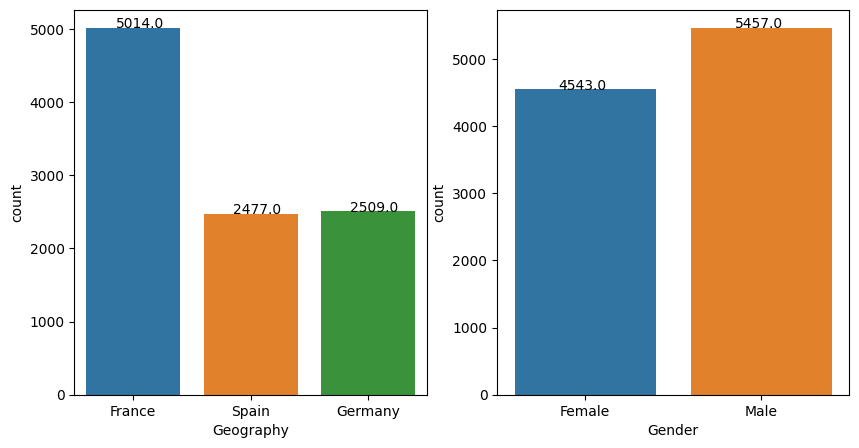

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(10, 5))
a = sns.countplot(x=df.Geography, ax=ax[0])
b = sns.countplot(x=df.Gender, ax=ax[1])

for p in a.patches:
   a.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

for p in b.patches:
   b.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

fig.show()

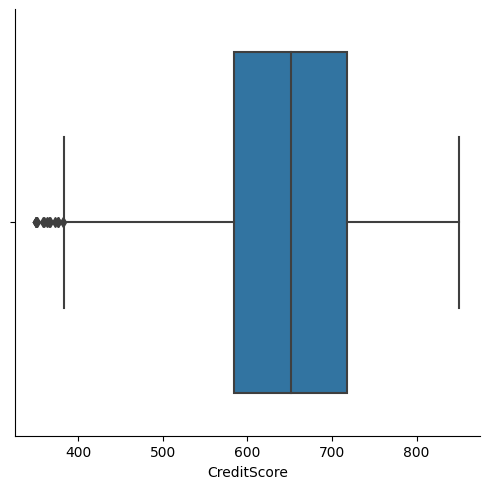

In [ ]:
sns.catplot(kind='box', x='CreditScore', data=df)

<Figure size 1500x800 with 0 Axes>

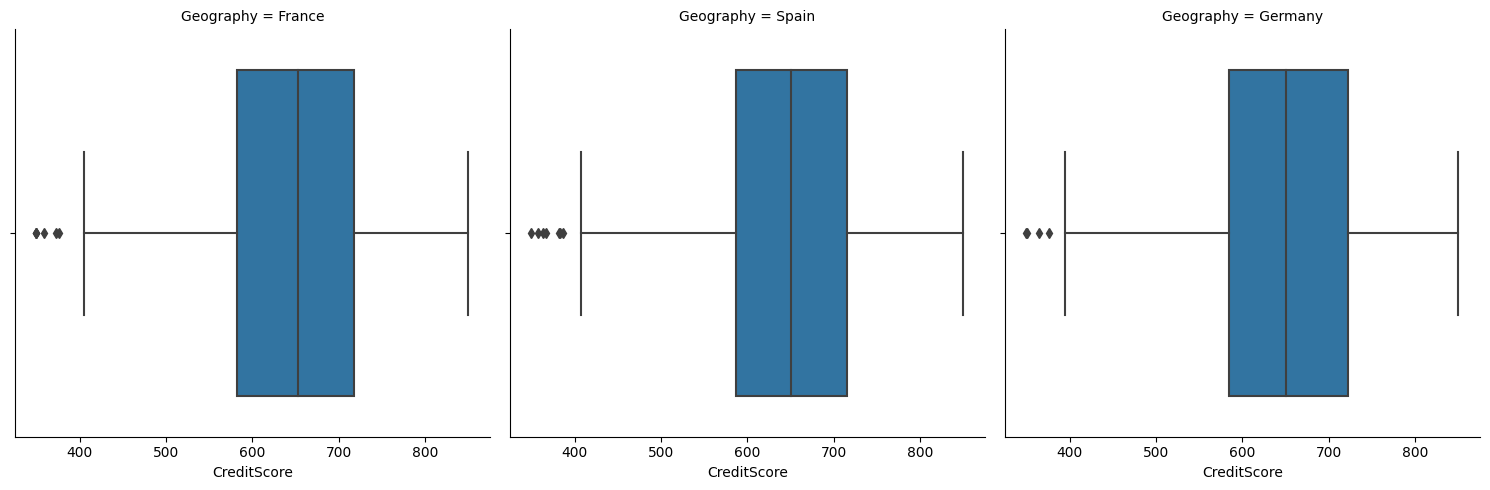

In [ ]:
plt.figure(figsize=(15, 8))
sns.catplot(kind='box', x='CreditScore', data=df, col='Geography')

<Figure size 1500x800 with 0 Axes>

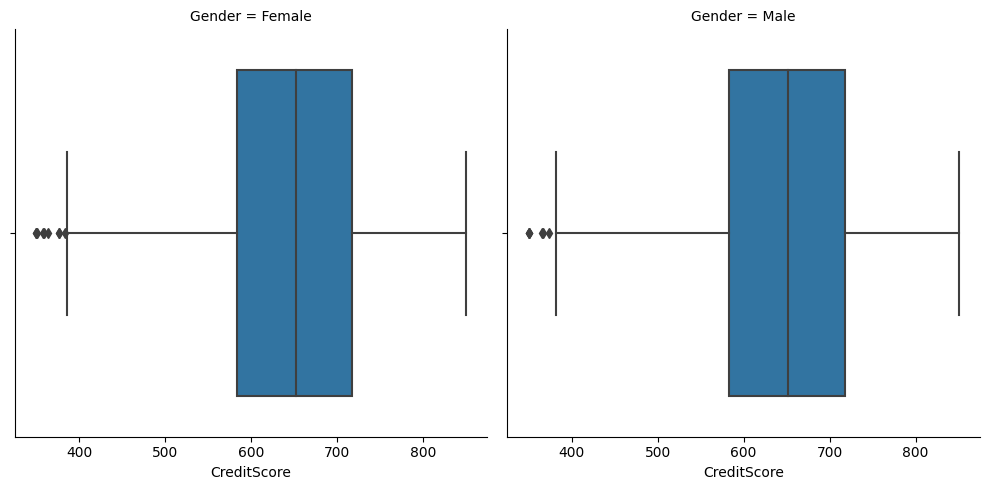

In [ ]:
plt.figure(figsize=(15, 8))
sns.catplot(kind='box', x='CreditScore', data=df, col='Gender')

In [ ]:
a = sns.countplot(x=df.Tenure, ax=ax[0])
for p in a.patches:
   a.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
fig.show()

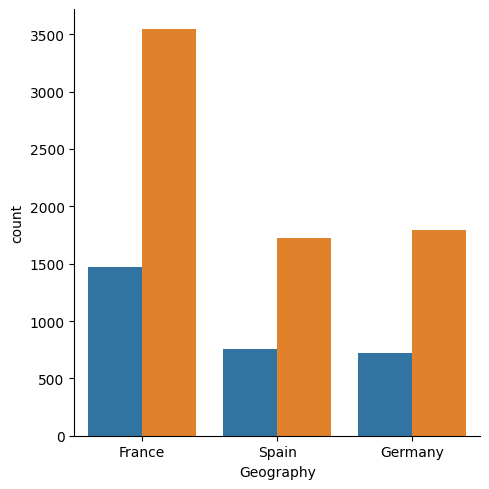

In [ ]:
b = sns.catplot(kind='count', x='Geography', hue='HasCrCard', data=df, legend=False)
fig.show()


Very less correlation is observed here,decent corelation between Age vs Exited


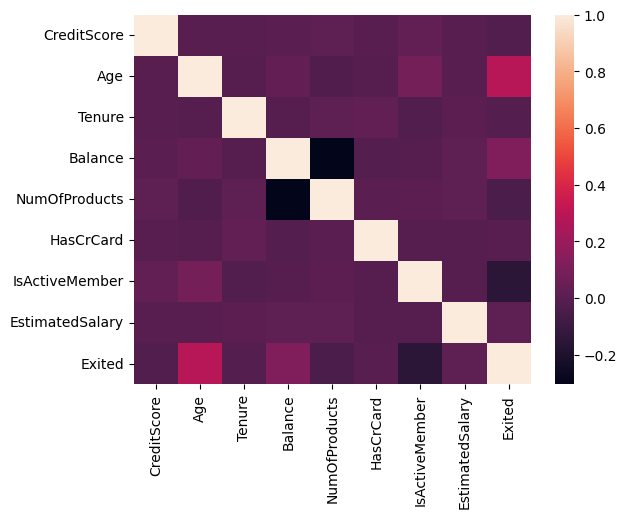

In [ ]:
sns.heatmap(data=df.corr())
print()
print("Very less correlation is observed here,decent corelation between Age vs Exited")

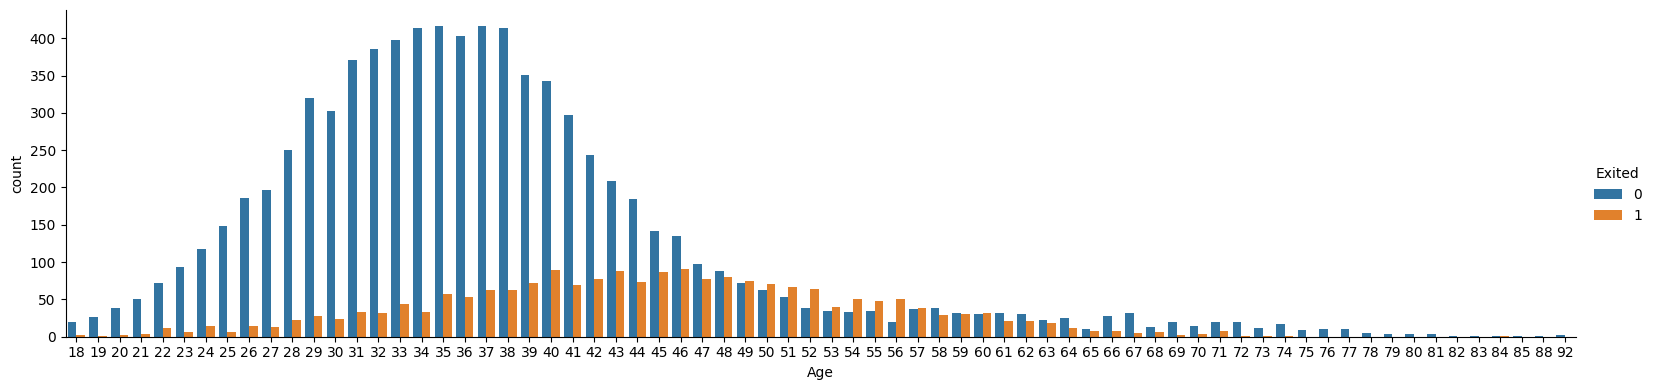

In [ ]:
a = sns.catplot(kind='count', x='Age', hue='Exited', data=df, height=4, aspect=16/4)
fig.show()

#Feature Engineering

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

num_features = ['Age', 'Balance', 'CreditScore', 'EstimatedSalary']
standardizer = StandardScaler()
standardized_df = pd.DataFrame(
                    standardizer.fit_transform(df[num_features]),
                    columns = num_features
)
standardized_df['Exited'] = df['Exited']

In [ ]:
#Converting categorical features into numeric
encoder = LabelEncoder()
encoded_df = pd.DataFrame()
cat_features = ['Geography' ,'Gender' ,'HasCrCard' ,'IsActiveMember' ,'NumOfProducts', 'Tenure']
for feature in cat_features:
  encoded_df[feature] = encoder.fit_transform(df[feature])

df = pd.concat([standardized_df,encoded_df],axis=1)
print(df.shape)
df.head()

(10000, 11)


,Age,Balance,CreditScore,EstimatedSalary,Exited,Geography,Gender,HasCrCard,IsActiveMember,NumOfProducts,Tenure
0,0.293517,-1.225848,-0.326221,0.021886,1,0,0,1,1,0,2
1,0.198164,0.117350,-0.440036,0.216534,0,2,0,0,1,0,1
2,0.293517,1.333053,-1.536794,0.240687,1,0,0,1,0,2,8
3,0.007457,-1.225848,0.501521,-0.108918,0,0,0,0,0,1,1
4,0.388871,0.785728,2.063884,-0.365276,0,2,0,1,1,0,2


In [ ]:
from sklearn.model_selection import train_test_split
features = df.drop(['Exited'], axis = 1)
target = df['Exited']
x, xTest, y, yTest = train_test_split(features,target , test_size = 0.2,random_state=42)
xTrain, x_cv, yTrain, y_cv= train_test_split(x, y, test_size =0.2,random_state=42)

In [ ]:
raw_xTrain = xTrain
raw_x_cv = x_cv
raw_yTrain = yTrain
raw_y_cv = y_cv
raw_xTest = xTest
raw_yTest = yTest

#Logistic Regression

### Logistic Regression(No sampling)

In [ ]:
def logistic_regression(xTrain,yTrain,xTest,yTest,x_cv, y_cv):
  grid={
      "C":np.logspace(-3,3,7),
      "penalty":["l1","l2"],
      'class_weight': [None, 'balanced']
      }
  logreg=LogisticRegression()
  gscv=GridSearchCV(logreg,grid,cv=10,scoring='f1')
  gscv.fit(x_cv,y_cv)

  print("Best parameters",gscv.best_params_)
  cv_f1_score_log1 = gscv.best_score_
  print("CV F1-score :",cv_f1_score_log1)


  log_reg = LogisticRegression(
                                C=gscv.best_params_['C'],
                                class_weight=gscv.best_params_['class_weight'],
                                penalty=gscv.best_params_['penalty']
  )
  log_reg.fit(xTrain, yTrain)
  y_pred = log_reg.predict(xTest)
  test_f1_score_log = f1_score(yTest,y_pred)
  print("Test F1 score:", test_f1_score_log)
  accuracy_log = accuracy_score(yTest, y_pred)
  print("Test Accuracy is:",accuracy_log)


  train_fpr, train_tpr, thresholds = roc_curve(yTrain,log_reg.predict_proba(xTrain)[:,1])
  test_fpr, test_tpr, thresholds = roc_curve(yTest,log_reg.predict_proba(xTest)[:,1])

  plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title("ROC")
  plt.show()

  fig= confusion_matrix(yTest,y_pred)
  labels= ["negative", "positive"]
  data= pd.DataFrame(fig, index = labels,columns = labels)
  sns.heatmap(data,annot=True,fmt="d")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted values")
  plt.ylabel("True values")
  plt.show()

  return test_f1_score_log, accuracy_log

Best parameters {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
CV F1-score : 0.5085221185123789
Test F1 score: 0.48479427549195
Test Accuracy is: 0.712


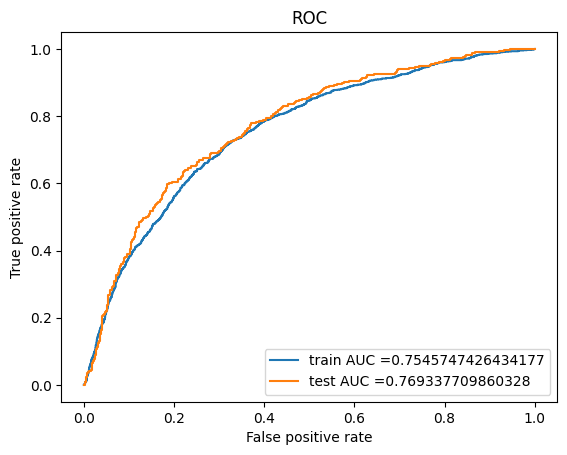

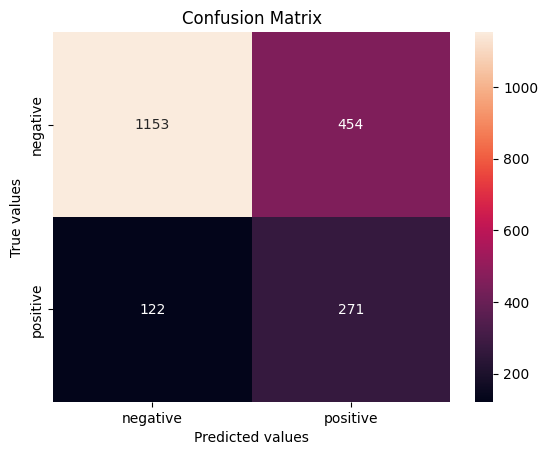

In [ ]:
test_f1_score_log1, accuracy_log1 = logistic_regression(xTrain,yTrain,xTest,yTest,x_cv, y_cv)

### Logistic regression(Up sampling)

In [ ]:
us =  RandomOverSampler()
xTrain_us, yTrain_us = us.fit_resample(xTrain, yTrain)
print('Original dataset shape {}'.format(Counter(yTrain)))
print('Resampled dataset shape {}'.format(Counter(yTrain_us)))


Original dataset shape Counter({0: 5083, 1: 1317})
Resampled dataset shape Counter({1: 5083, 0: 5083})


Best parameters {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
CV F1-score : 0.5085221185123789
Test F1 score: 0.48177777777777775
Test Accuracy is: 0.7085


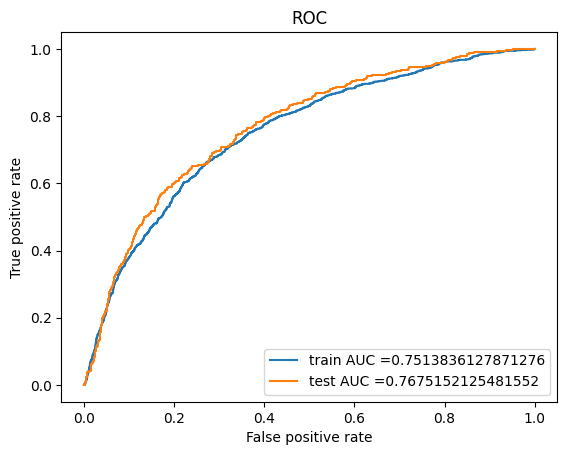

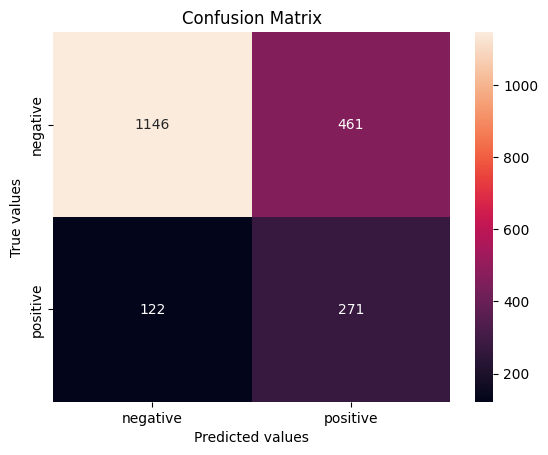

In [ ]:
test_f1_score_log2, accuracy_log2 = logistic_regression(xTrain_us,yTrain_us,xTest,yTest,x_cv, y_cv)

### Logistic regression(Down sampling)

In [ ]:
ds =  ClusterCentroids()
xTrain_ds, yTrain_ds = ds.fit_resample(raw_xTrain, raw_yTrain)
print('Original dataset shape {}'.format(Counter(raw_yTrain)))
print('Resampled dataset shape {}'.format(Counter(yTrain_ds)))

Original dataset shape Counter({0: 5083, 1: 1317})
Resampled dataset shape Counter({0: 1317, 1: 1317})


Best parameters {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
CV F1-score : 0.5085221185123789
Test F1 score: 0.4395061728395062
Test Accuracy is: 0.6595


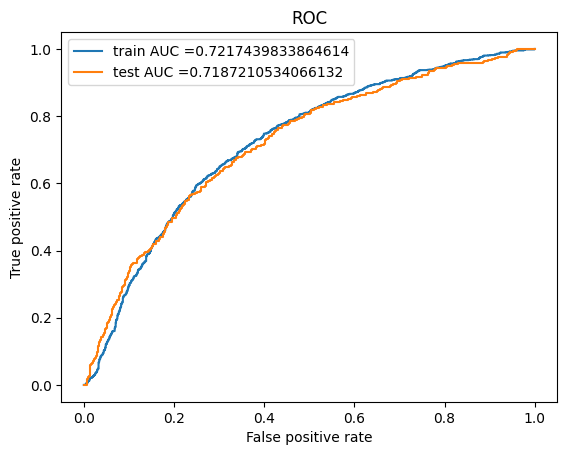

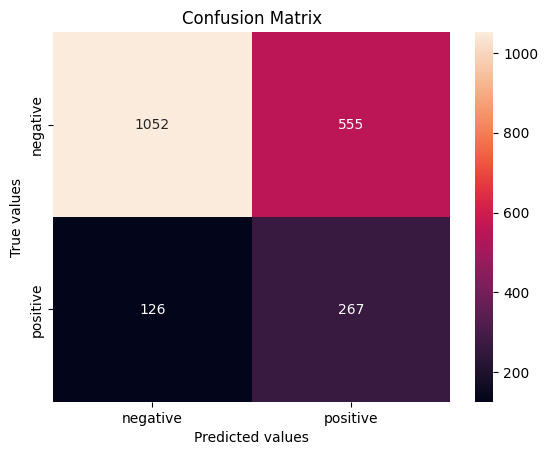

In [ ]:
test_f1_score_log3, accuracy_log3 = logistic_regression(xTrain_ds,yTrain_ds,xTest,yTest,x_cv, y_cv)

## Logistic regression(SMOTE-ENN)

In [ ]:
rs =  SMOTEENN()
xTrain_rs, yTrain_rs = rs.fit_resample(raw_xTrain, raw_yTrain)
print('Original dataset shape {}'.format(Counter(raw_yTrain)))
print('Resampled dataset shape {}'.format(Counter(yTrain_rs)))

Original dataset shape Counter({0: 5083, 1: 1317})
Resampled dataset shape Counter({1: 4551, 0: 3131})


Best parameters {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
CV F1-score : 0.5085221185123789
Test F1 score: 0.4677966101694916
Test Accuracy is: 0.686


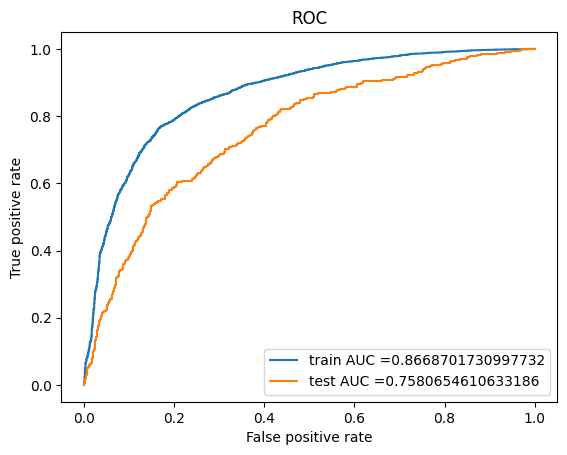

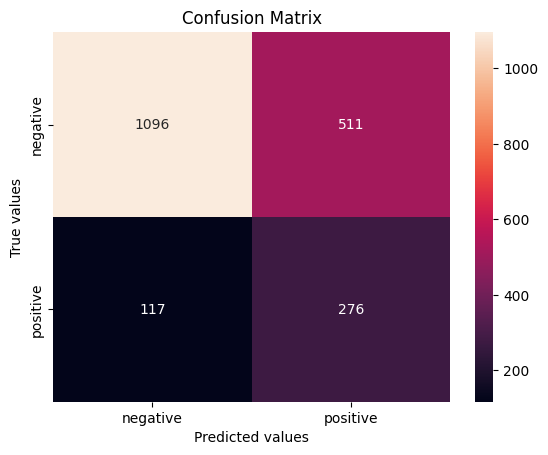

In [ ]:
test_f1_score_log4, accuracy_log4 = logistic_regression(xTrain_rs,yTrain_rs,xTest,yTest,x_cv, y_cv)

In [ ]:
print(test_f1_score_log1,
test_f1_score_log2,
test_f1_score_log3,
test_f1_score_log4)

0.48479427549195 0.48177777777777775 0.4395061728395062 0.4677966101694916


In [ ]:
print(
accuracy_log1,
accuracy_log2,
accuracy_log3,
accuracy_log4)

0.712 0.7085 0.6595 0.686


In [ ]:
xTrain = raw_xTrain
x_cv = raw_x_cv
yTrain = raw_yTrain
y_cv = raw_y_cv
xTest = raw_xTest
yTest = raw_yTest

# Linear Classifier(Ridge)




## Linear classifier(No Sampling)

In [ ]:
def linear_classifier(xTrain,yTrain,xTest,yTest,x_cv, y_cv):
  params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0,
                      10.0, 20, 50, 100, 500, 1000 ]}
  ridge = RidgeClassifier()
  grid_cv_model = GridSearchCV(estimator=ridge,
                        param_grid=params,
                        cv=5,
                        return_train_score=True)
  grid_cv_model.fit(x_cv, y_cv)
  print(f"Best Parameters: {grid_cv_model.best_params_}")

  ridge = RidgeClassifier(**grid_cv_model.best_params_)
  ridge.fit(xTrain,yTrain)
  y_pred = ridge.predict(xTest)
  test_f1_score_ridge = f1_score(yTest,y_pred)
  print("Test F1 score:", test_f1_score_ridge)
  accuracy_ridge = accuracy_score(yTest, y_pred)
  print("Test Accuracy is:",accuracy_ridge)

  train_fpr, train_tpr, thresholds = roc_curve(yTrain,ridge.decision_function(xTrain))
  test_fpr, test_tpr, thresholds = roc_curve(yTest,ridge.decision_function(xTest))

  plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title("ROC")
  plt.show()

  fig= confusion_matrix(yTest,y_pred)
  labels= ["negative", "positive"]
  data= pd.DataFrame(fig, index = labels,columns = labels)
  sns.heatmap(data,annot=True,fmt="d")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted values")
  plt.ylabel("True values")
  plt.show()

  return test_f1_score_ridge, accuracy_ridge

Best Parameters: {'alpha': 0.0001}
Test F1 score: 0.13566739606126915
Test Accuracy is: 0.8025


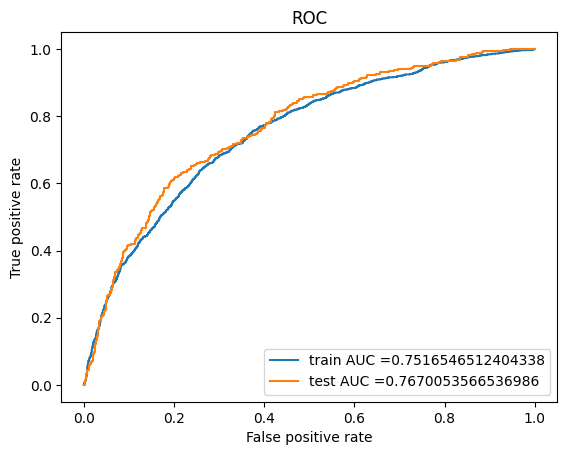

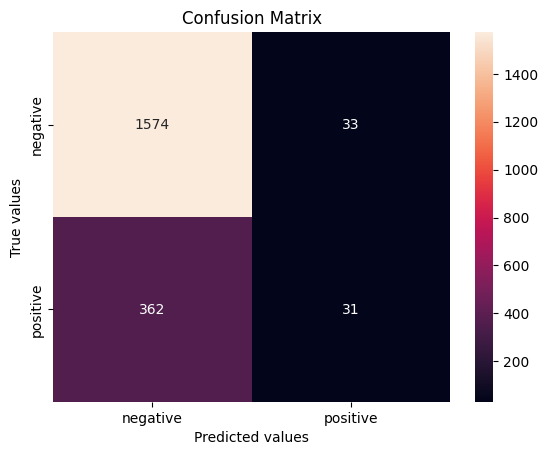

In [ ]:
test_f1_score_ridge1, accuracy_ridge1 = linear_classifier(xTrain,yTrain,xTest,yTest,x_cv, y_cv)

## Linear classifier(Up Sampling)

Best Parameters: {'alpha': 0.0001}
Test F1 score: 0.46944198405668736
Test Accuracy is: 0.7005


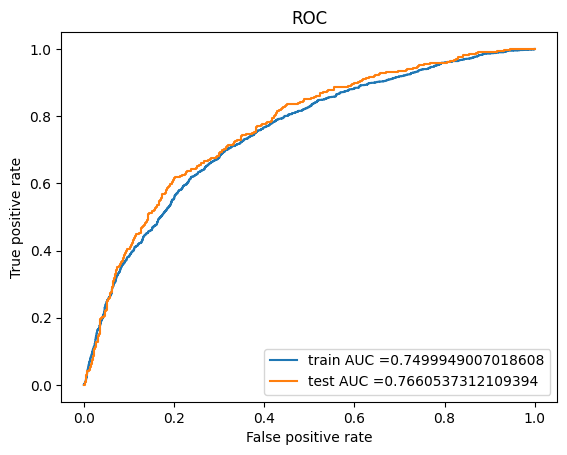

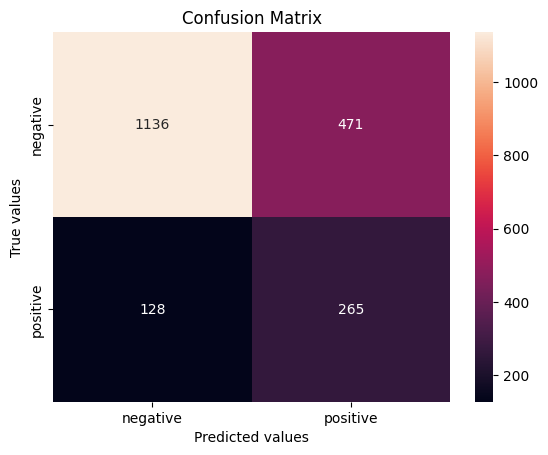

In [ ]:
test_f1_score_ridge2, accuracy_ridge2 = linear_classifier(xTrain_us,yTrain_us,xTest,yTest,x_cv, y_cv)

## Linear classifier(Down Sampling)

Best Parameters: {'alpha': 0.0001}
Test F1 score: 0.42122186495176844
Test Accuracy is: 0.64


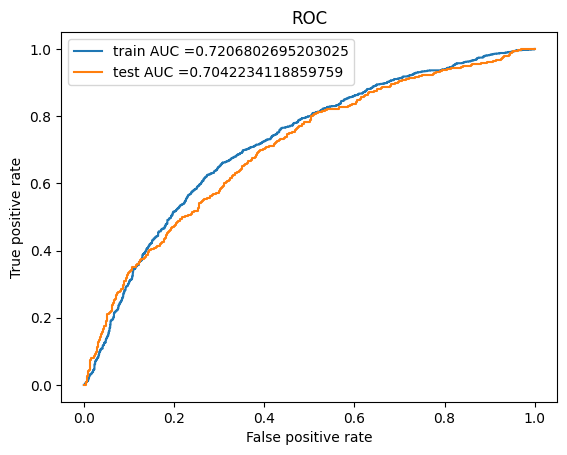

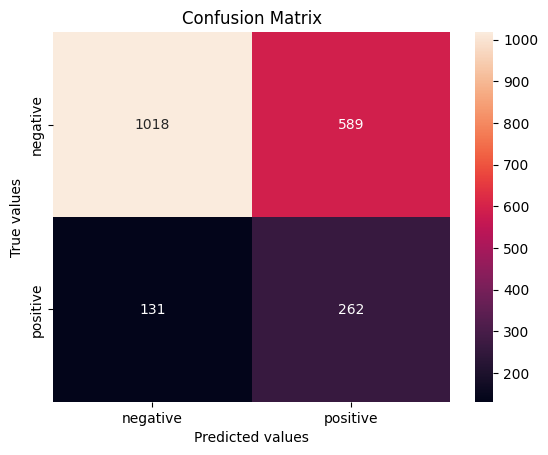

In [ ]:
test_f1_score_ridge3, accuracy_ridge3 = linear_classifier(xTrain_ds,yTrain_ds,xTest,yTest,x_cv, y_cv)

## Linear classifier(SMOTE-ENN)

Best Parameters: {'alpha': 0.0001}
Test F1 score: 0.45098039215686275
Test Accuracy is: 0.636


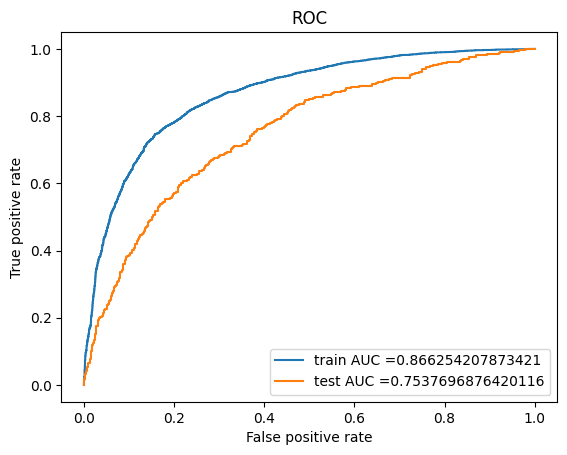

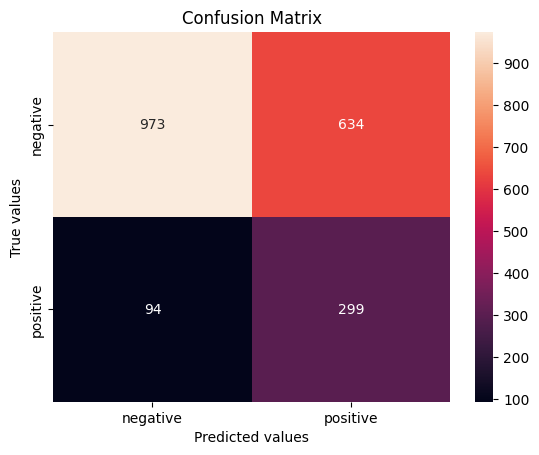

In [ ]:
test_f1_score_ridge4, accuracy_ridge4 = linear_classifier(xTrain_rs,yTrain_rs,xTest,yTest,x_cv, y_cv)

In [ ]:
xTrain = raw_xTrain
x_cv = raw_x_cv
yTrain = raw_yTrain
y_cv = raw_y_cv
xTest = raw_xTest
yTest = raw_yTest

# Naive Bayes

## Naive Bayes(No Sampling)

In [ ]:
def NB(xTrain,yTrain,xTest,yTest,x_cv, y_cv):
  params = {'var_smoothing': np.logspace(0,-9, num=100)}
  GNB = GaussianNB()
  grid_cv_model = GridSearchCV(param_grid = params, estimator = GNB, cv = 5, verbose = 1)
  grid_cv_model.fit(x_cv, y_cv)
  print(f"Best Parameters: {grid_cv_model.best_params_}")

  GNB = GaussianNB(**grid_cv_model.best_params_)
  GNB.fit(xTrain,yTrain)
  y_pred = GNB.predict(xTest)
  test_f1_score_nb = f1_score(yTest,y_pred)
  print("Test F1 score:", test_f1_score_nb)
  accuracy_nb = accuracy_score(yTest, y_pred)
  print("Test Accuracy is:",accuracy_nb)

  train_fpr, train_tpr, thresholds = roc_curve(yTrain,GNB.predict_proba(xTrain)[:,1])
  test_fpr, test_tpr, thresholds = roc_curve(yTest,GNB.predict_proba(xTest)[:,1])

  plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title("ROC")
  plt.show()

  fig= confusion_matrix(yTest,y_pred)
  labels= ["negative", "positive"]
  data= pd.DataFrame(fig, index = labels,columns = labels)
  sns.heatmap(data,annot=True,fmt="d")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted values")
  plt.ylabel("True values")
  plt.show()

Best parameters {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
CV F1-score : 0.5085221185123789
Test F1 score: 0.48479427549195
Test Accuracy is: 0.712


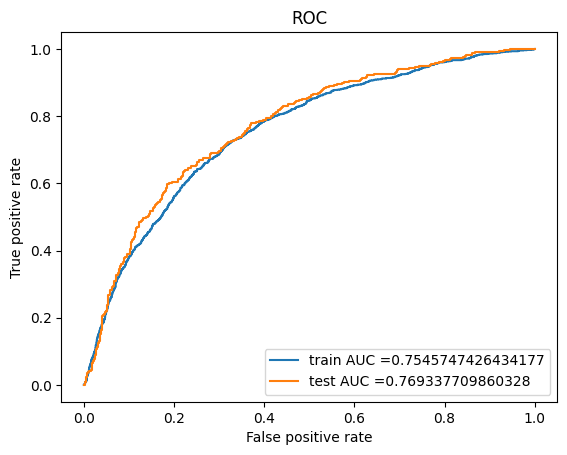

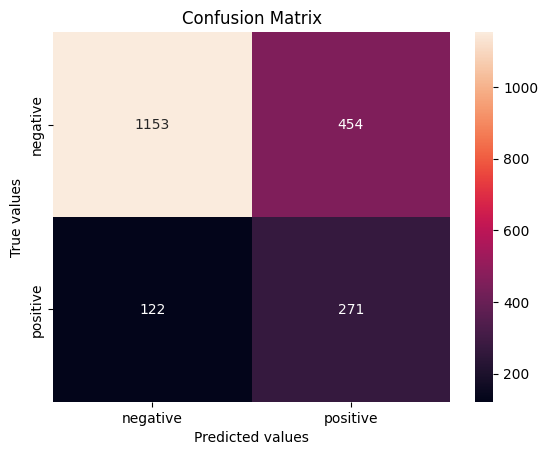

In [ ]:
test_f1_score_nb1, accuracy_nb1 = logistic_regression(xTrain,yTrain,xTest,yTest,x_cv, y_cv)

## Naive Bayes(Up Sampling)

Best parameters {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
CV F1-score : 0.5085221185123789
Test F1 score: 0.48177777777777775
Test Accuracy is: 0.7085


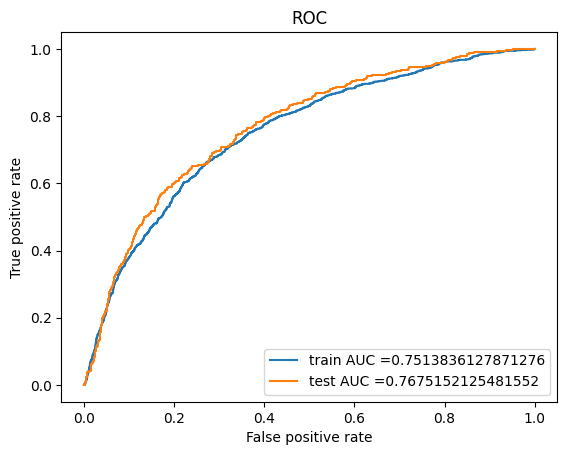

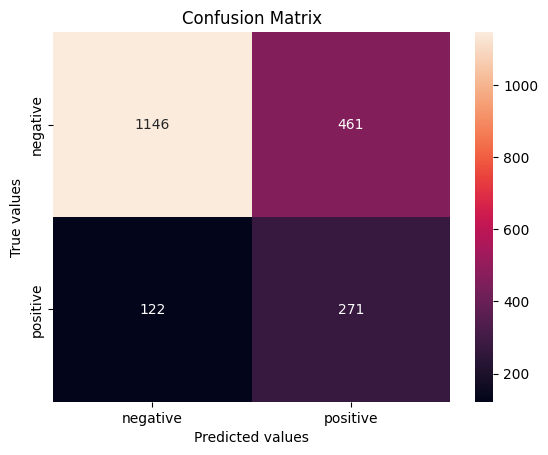

In [ ]:
test_f1_score_nb2, accuracy_nb2 = logistic_regression(xTrain_us,yTrain_us,xTest,yTest,x_cv, y_cv)

## Naive Bayes(Down Sampling)

Best parameters {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
CV F1-score : 0.5085221185123789
Test F1 score: 0.4395061728395062
Test Accuracy is: 0.6595


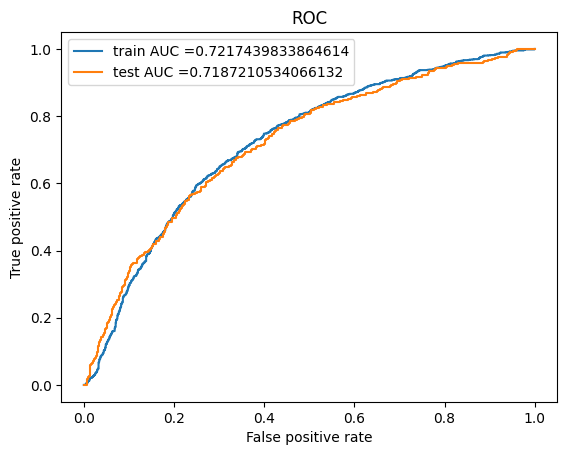

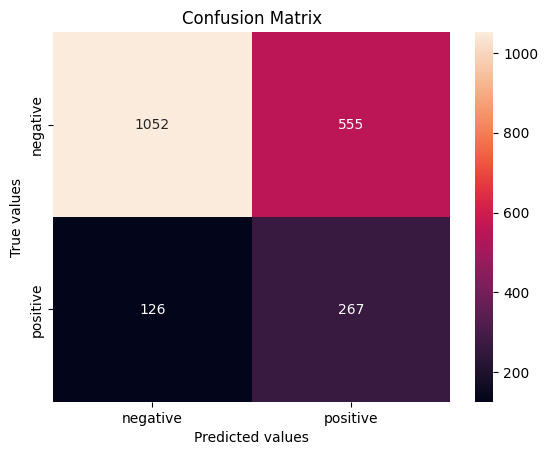

In [ ]:
test_f1_score_nb3, accuracy_nb3 = logistic_regression(xTrain_ds,yTrain_ds,xTest,yTest,x_cv, y_cv)

## Naive Bayes(SMOTE-ENN)

Best parameters {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
CV F1-score : 0.5085221185123789
Test F1 score: 0.4677966101694916
Test Accuracy is: 0.686


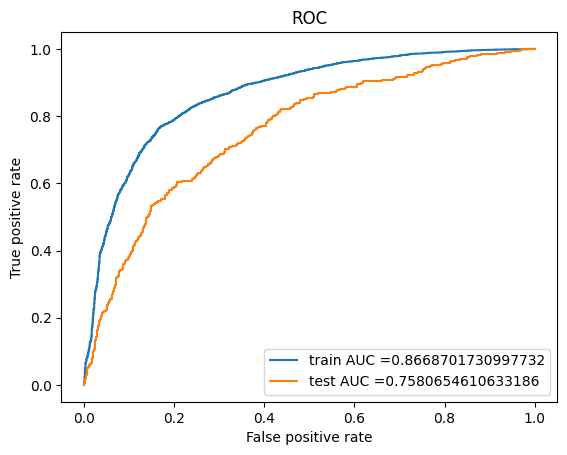

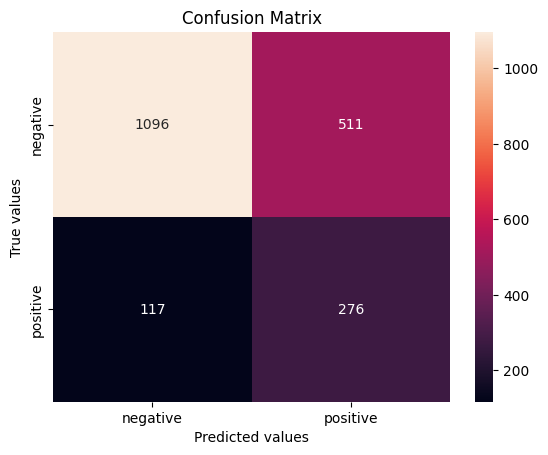

In [ ]:
test_f1_score_nb4, accuracy_nb4 = logistic_regression(xTrain_rs,yTrain_rs,xTest,yTest,x_cv, y_cv)

In [ ]:
xTrain = raw_xTrain
x_cv = raw_x_cv
yTrain = raw_yTrain
y_cv = raw_y_cv
xTest = raw_xTest
yTest = raw_yTest

## Random forest

In [ ]:
from random import randint
from sklearn.ensemble import RandomForestClassifier
def RF(xTrain,yTrain,xTest,yTest,x_cv, y_cv):
  params = {"n_estimators": range(1,24,8),
          "max_features": ['auto', 'sqrt'],
          "min_samples_split" : range(1, 10,5),
          "min_samples_leaf": range(1, 10,5),
          "max_depth" : [2,4],
          'criterion': ['gini', 'entropy'],
          "bootstrap": [True, False]}
  RF = RandomForestClassifier()
  grid_cv_model = GridSearchCV(param_grid = params, estimator = RF, cv = 5, verbose = 1)
  grid_cv_model.fit(x_cv, y_cv)
  print(f"Best Parameters: {grid_cv_model.best_params_}")

  RF = RandomForestClassifier(**grid_cv_model.best_params_)
  RF.fit(xTrain,yTrain)
  y_pred = RF.predict(xTest)
  test_f1_score_rf = f1_score(yTest,y_pred)
  print("Test F1 score:", test_f1_score_rf)
  accuracy_rf = accuracy_score(yTest, y_pred)
  print("Test Accuracy is:",accuracy_rf)

  train_fpr, train_tpr, thresholds = roc_curve(yTrain,RF.predict_proba(xTrain)[:,1])
  test_fpr, test_tpr, thresholds = roc_curve(yTest,RF.predict_proba(xTest)[:,1])

  plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title("ROC")
  plt.show()

  fig= confusion_matrix(yTest,y_pred)
  labels= ["negative", "positive"]
  data= pd.DataFrame(fig, index = labels,columns = labels)
  sns.heatmap(data,annot=True,fmt="d")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted values")
  plt.ylabel("True values")
  plt.show()
  return test_f1_score_rf,accuracy_rf

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 17}
Test F1 score: 0.46511627906976744
Test Accuracy is: 0.8505


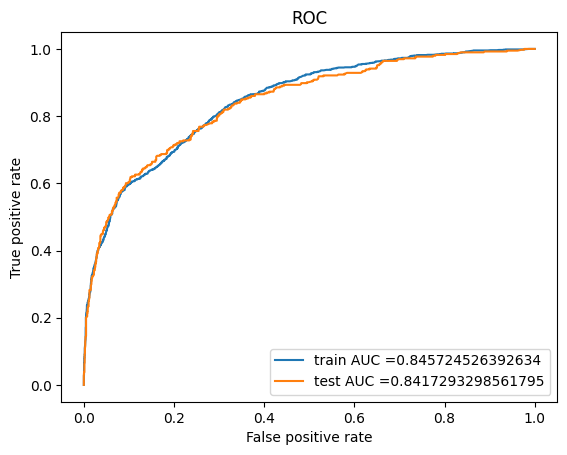

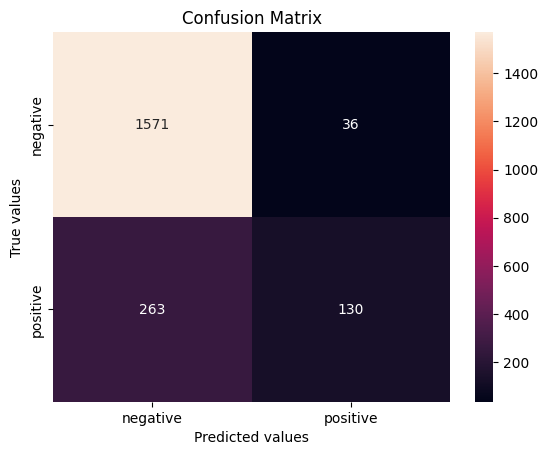

In [ ]:
test_f1_score_rf1, accuracy_rf1 = RF(xTrain,yTrain,xTest,yTest,x_cv, y_cv)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 9}
Test F1 score: 0.5729166666666666
Test Accuracy is: 0.795


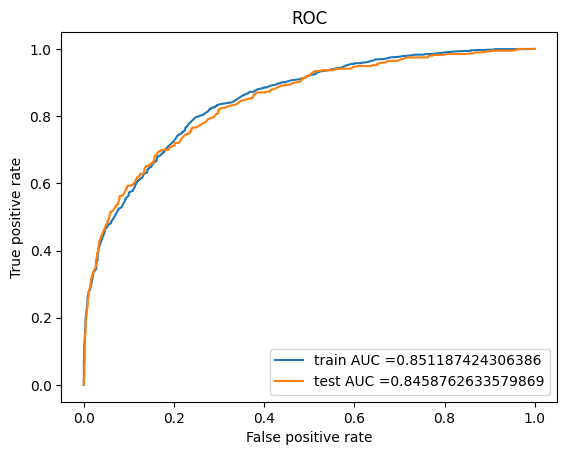

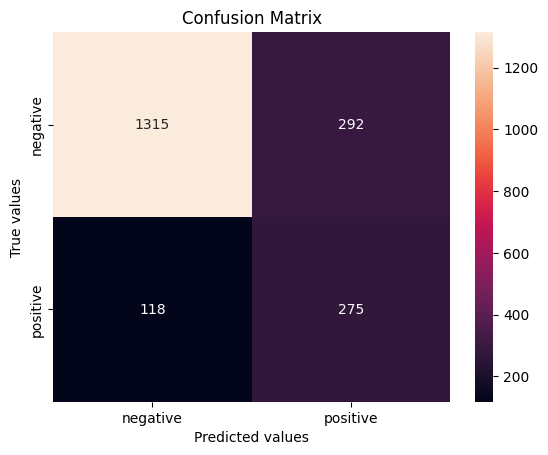

In [ ]:
test_f1_score_rf2, accuracy_rf2 = RF(xTrain_us,yTrain_us,xTest,yTest,x_cv, y_cv)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 17}
Test F1 score: 0.5231846019247594
Test Accuracy is: 0.7275


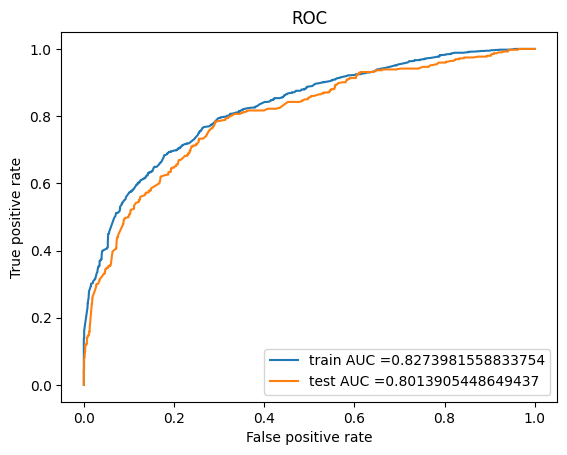

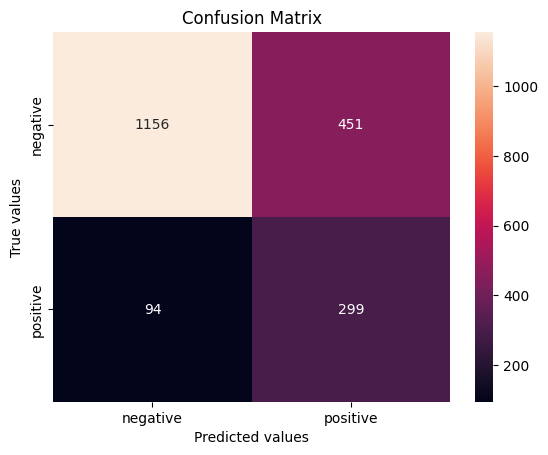

In [ ]:
test_f1_score_rf3, accuracy_rf3 = RF(xTrain_ds,yTrain_ds,xTest,yTest,x_cv, y_cv)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 17}
Test F1 score: 0.5000000000000001
Test Accuracy is: 0.673


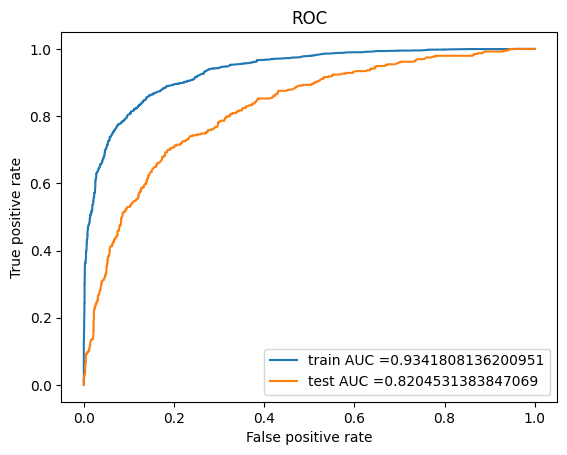

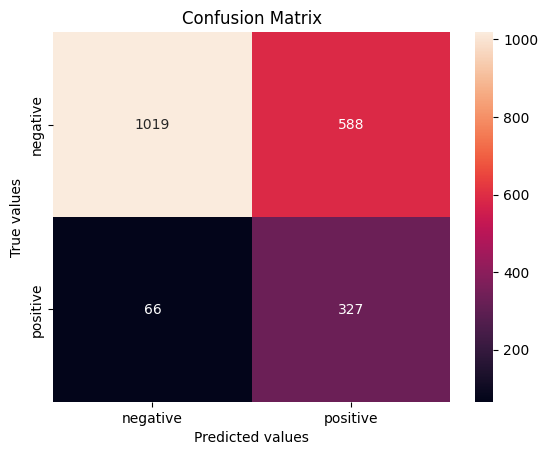

In [ ]:
test_f1_score_rf4, accuracy_rf4 = RF(xTrain_rs,yTrain_rs,xTest,yTest,x_cv, y_cv)

# RESULTS

In [ ]:
from prettytable import PrettyTable


myTable = PrettyTable(["Algorithm", "Sampling", "F1-Score", "Accuracy"])


myTable.add_row(["Logistic Regression","No sampling",f"{round(test_f1_score_log1,3)}",f"{accuracy_log1}"])
myTable.add_row(["Logistic Regression","Up sampling",f"{round(test_f1_score_log2,3)}",f"{accuracy_log2}"])
myTable.add_row(["Logistic Regression","Down sampling",f"{round(test_f1_score_log3,3)}",f"{accuracy_log3}"])
myTable.add_row(["Logistic Regression","SMOTE-ENN",f"{round(test_f1_score_log4,3)}",f"{accuracy_log4}"])
myTable.add_row(["Ridge Classifier","No sampling",f"{round(test_f1_score_ridge1,3)}",f"{accuracy_ridge1}"])
myTable.add_row(["Ridge Classifier","Up sampling",f"{round(test_f1_score_ridge2,3)}",f"{accuracy_ridge2}"])
myTable.add_row(["Ridge Classifier","Down sampling",f"{round(test_f1_score_ridge3,3)}",f"{accuracy_ridge3}"])
myTable.add_row(["Ridge Classifier","SMOTE-ENN",f"{round(test_f1_score_ridge4,3)}",f"{accuracy_ridge4}"])
myTable.add_row(["Naive bayes","No sampling",f"{round(test_f1_score_nb1,3)}",f"{accuracy_nb1}"])
myTable.add_row(["Naive bayes","Up sampling",f"{round(test_f1_score_nb2,3)}",f"{accuracy_nb2}"])
myTable.add_row(["Naive bayes","Down sampling",f"{round(test_f1_score_nb3,3)}",f"{accuracy_nb3}"])
myTable.add_row(["Naive bayes","SMOTE-ENN",f"{round(test_f1_score_nb4,3)}",f"{accuracy_nb4}"])
myTable.add_row(["Random Forest","No sampling",f"{round(test_f1_score_rf1,3)}",f"{accuracy_rf1}"])
myTable.add_row(["Random Forest","Up sampling",f"{round(test_f1_score_rf2,3)}",f"{accuracy_rf2}"])
myTable.add_row(["Random Forest","Down sampling",f"{round(test_f1_score_rf3,3)}",f"{accuracy_rf3}"])
myTable.add_row(["Random Forest","SMOTE-ENN",f"{round(test_f1_score_rf4,3)}",f"{accuracy_rf4}"])

print(myTable)

+---------------------+---------------+----------+----------+
|      Algorithm      |    Sampling   | F1-Score | Accuracy |
+---------------------+---------------+----------+----------+
| Logistic Regression |  No sampling  |  0.485   |  0.712   |
| Logistic Regression |  Up sampling  |  0.482   |  0.7085  |
| Logistic Regression | Down sampling |   0.44   |  0.6595  |
| Logistic Regression |   SMOTE-ENN   |  0.468   |  0.686   |
|   Ridge Classifier  |  No sampling  |  0.136   |  0.8025  |
|   Ridge Classifier  |  Up sampling  |  0.469   |  0.7005  |
|   Ridge Classifier  | Down sampling |  0.421   |   0.64   |
|   Ridge Classifier  |   SMOTE-ENN   |  0.451   |  0.636   |
|     Naive bayes     |  No sampling  |  0.485   |  0.712   |
|     Naive bayes     |  Up sampling  |  0.482   |  0.7085  |
|     Naive bayes     | Down sampling |   0.44   |  0.6595  |
|     Naive bayes     |   SMOTE-ENN   |  0.468   |  0.686   |
|    Random Forest    |  No sampling  |  0.465   |  0.8505  |
|    Ran